<a href="https://colab.research.google.com/github/ds-modules/data-4ac/blob/master/ALPR/ALPR_Notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# License Plate Recognition Surveillance in Oakland

## 1. Introduction

**In this assignment, we will be working with Automated License Plate Reader (ALPR) data from the Oakland, CA Police Department.**

The data we will be using in this assignment has previously been used in Data 8 to teach a lesson about privacy. In that lesson, students were introduced to Oakland ALPR data and used the data to track the whereabouts of a former Mayor of Oakland. Students thus considered some of the privacy concerns that ALPR data raise, including giving those with access to the data the ability to determine where people live, work, and what they do in their free time. One of the conclusions of the privacy lecture was that data collected for one purpose (such as to “fight crime”) can reveal a lot more than initially intended. **We carry this same objective over to this new assignment, in which we aim to introduce you to the social and historical contexts of Automated License Plate Reader data, and how the collection and use of this data distributes risks among different population groups unevenly.**

### A. Background



Automated License Plate Readers, which are usually mounted on police cars, capture digital license plate data and images for law enforcement purposes (Policy Manual). In particular, the Oakland Police Department writes in their ALPR policy manual that the data can be used for “identifying stolen or wanted vehicles, stolen license plates and missing persons. It may also be used to gather information related to active warrants, suspect interdiction and stolen property recovery” (Policy Manual). As of 2015, Oakland PD operated 33 license plate readers, each of which can scan up to 60 license plates per second (Ars Technica). Thus, Oakland PD stores millions of records, of which only a small portion are associated with a criminal investigation (ACLU). While Oakland PD says that its data collection and storage procedures adhere to privacy rights, including purging unused data after 6 months and restricting the sharing of data, it is crucial to note that millions of Oakland PD license plate records are available online – this is how we found the data for this assignment (Policy Manual). In addition, while the Supreme Court has ruled that cars on public roads do not have a reasonable expectation of privacy, it is important to remember that “reasonable suspicion or probable cause is not required before using an ALPR to scan license plates or collect data” (Policy Manual).  

### B. Introductory Questions

**Q0a:** What is one reason that Oakland PD gives for collecting ALPR data? 

*Answer here*

**Q0b:** What is one drawback to collecting and using ALPR data?

*Answer here*

## 2. ALPR Data

In [ ]:
!apt install libspatialindex-dev
!pip install rtree
!pip install geopandas

Reading package lists... Done
Building dependency tree       
Reading state information... Done
libspatialindex-dev is already the newest version (1.8.5-5).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 12 not upgraded.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import warnings
warnings.filterwarnings('ignore')

from datascience import *
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import normalize

%matplotlib inline
plt.style.use('fivethirtyeight')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


All available ALPR data can be found [here](https://data.oaklandca.gov/browse?q=alpr&sortBy=relevance). We are working with the most recent available data (4/1/14 - 5/31/14).

In [ ]:
alpr = Table().read_table("/content/drive/MyDrive/Colab Notebooks/ALPR/lprs-data.csv")
alpr

red_VRM | red_Timestamp          | Location 1
6EZZ778 | 05/31/2014 12:41:00 PM | (37.838856, -122.221971)
4VLN123 | 05/31/2014 12:41:00 PM | (37.838911, -122.222023)
6EJR528 | 05/31/2014 12:41:00 PM | (37.838911, -122.222023)
5BEJ534 | 05/31/2014 12:41:00 PM | (37.83896, -122.222071)
6WQN812 | 05/31/2014 12:41:00 PM | (37.839103, -122.22221)
5RJP156 | 05/31/2014 12:41:00 PM | (37.839228, -122.222323)
5RZT811 | 05/31/2014 12:41:00 PM | (37.839295, -122.222388)
7CHA147 | 05/31/2014 12:41:00 PM | (37.839596, -122.222893)
7EEW593 | 05/31/2014 12:41:00 PM | (37.839593, -122.222883)
6PBE505 | 05/31/2014 12:40:00 PM | (37.84137, -122.224333)
... (328572 rows omitted)

**Q1**: What can we learn from the table `alpr`? What do the columns represent, and what do the rows represent?

*Answer here*

**Q2**: How many license plate readings are in our data from 4/1/14 - 5/31/14? follow-up... 

*Answer here*

**Q3:** We would like to relabel our columns, split our location to seperate latitude and longitude columns, as well as sort the ALPR data by Timestamp in chronological order as a first step in cleaning `alpr`.

Consider the following column names in our final result: 'Plate', 'Timestamp', 'Latitude', and 'Longitude'.

In [ ]:
def getlatitude(s):
    before, after = s.split(',') # Break it into two parts
    latstring = before[1:] # Get rid of the annoying '('
    return float(latstring) # Convert the string to a number
def getlongitude(s):
    before, after = s.split(',') # Break it into two parts
    longstring = after[1:-1] # Get rid of the ' ' and the ')'
    return float(longstring) # Convert the string to a number

In [ ]:
# Relabel columns 
alpr = alpr.relabeled("red_VRM", "Plate").relabeled("red_Timestamp", "Timestamp")

# Split Location to 'Latitude' and 'Longitude' columns
alpr = alpr.with_columns("Latitude", alpr.apply(getlatitude, "Location 1"), "Longitude", alpr.apply(getlongitude, "Location 1")).drop("Location 1")

# Sort the LPRS data by Timestamp in chronological order
alpr = alpr.sort("Timestamp", descending=False)

In [ ]:
alpr

Plate   | Timestamp              | Latitude | Longitude
6LWL396 | 04/01/2014 01:00:00 PM | 37.8048  | -122.251
4DGR470 | 04/01/2014 01:00:00 PM | 37.7938  | -122.253
6RIP575 | 04/01/2014 01:00:00 PM | 37.8047  | -122.251
4ZDX994 | 04/01/2014 01:00:00 PM | 37.8046  | -122.251
6XJW220 | 04/01/2014 01:00:00 PM | 37.8046  | -122.251
6J44213 | 04/01/2014 01:00:00 PM | 37.8042  | -122.252
6B03075 | 04/01/2014 01:00:00 PM | 37.8042  | -122.252
4PKP608 | 04/01/2014 01:00:00 PM | 37.794   | -122.255
4RPB940 | 04/01/2014 01:00:00 PM | 37.7939  | -122.255
5MBD011 | 04/01/2014 01:00:00 PM | 37.7921  | -122.248
... (328572 rows omitted)

## 3. Exploratory Data Analysis on ALPR Data

### Distributions

In [ ]:
plate_counts = alpr.group("Plate").sort("count", descending=True).relabel("count", "times seen")

In [ ]:
plate_counts

NameError: ignored

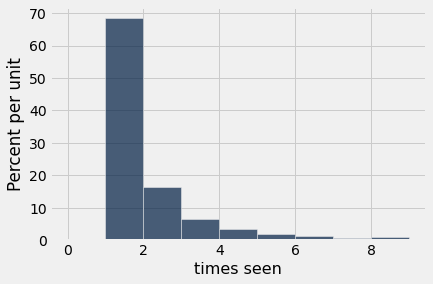

In [ ]:
plate_counts.hist('times seen', bins=np.arange(0, 10, 1))

In [ ]:
plate_counts_above_10 = plate_counts.where("times seen", are.above_or_equal_to(10)).num_rows

In [ ]:
plate_counts_above_10

2117

**Q:** Can we compare plate counts for each unique plate to the number of registered vehicles in Oakland? What are the implications of this result? What is the gap between these two pieces of information?

### Maps 

Lets use some maps to visualize the data. First, let's take a look at the first 1000 readings, starting on 4/01/2014.

The following are functions we use to display maps. You are not required to learn how to use them, but the docstring explains the workings.

In [ ]:
def dot_map(tbl):
    """Create a map with dots to represent a unique location.
    
    Parameters:
        tbl (datascience.Table): The Table containing the data needed to plot our map. Note the table
        must have a "Latitude" and "Longitude" column for this function to work.
    Returns:
        (datascience.Map): A map with a dot at each unique (lat, long) pair.
    """
    reduced = tbl.select("Latitude", "Longitude")
    return Circle.map_table(reduced, area=10, fill_opacity=1)

In [ ]:
def size_map(tbl):
    """Plots a geographical map where each dot represents a coordinate pair, scaled by a given column.
    
    Parameters:
        tbl: The input Table containing the following arguments, in order:
            Col 0: latitude
            Col 1: longitude
            Col 2: type of location
            Col 3: color (MUST be labeled "colors")
            Col 4: area (MUST be labeled "areas")
    Returns:
        (datascience.Map): A map with a dot at each (lat, long),
                        colored according to Col 3,area as in Col 4.
    """
    return Circle.map_table(tbl, fill_opacity=0.7)

In [ ]:
dot_map(alpr.take(np.arange(5000)))

**Q:** Ooops! Seems like there is a data point that is an outlier due to an incorrect recording. An invalid recording could have implications on our analysis and conclusions. Let's take a look into this.

## 4. Exploratory Data Analysis on Census Data

In addition to ALPR data, we will be using census tract data for the City of Oakland in this assignment. Census tracts are “small, relatively permanent statistical subdivisions of a county” that contain an average of 4,000 inhabitants (census.gov). Census tracts are updated once every ten years. Depending on population changes within census tracts, they may be split or merged during this process. However, census tracts are designed to be relatively permanent over time, and any changes are documented so that data can be compared from decade to decade. Local constituents are also invited to participate in the drawing of census tracts through the Participant Statistical Areas Program. Many different types of data are collected by census tract, including demographic data (e.g. race/ethnicity, age), socioeconomic data (e.g. poverty and unemployment rates), education data, biometric data (e.g. asthma rates, low birth rate rates), and environmental data (e.g. pollution and traffic levels). We will be working with some of this data to analyze relationships between police surveillance and characteristics of census tracts.

**INCLUDE BLURB ON CENSUS TRACTS**

Here is a dictionary with a description of all of the features available in our census data. It is a subset of the California Environmental Protection Agency (CalEPA) CalEnviroScreen project... You can find the original data [here]().

<br/>

|Feature|Description|
|---|---|
|Census Tract|	Census Tract ID from 2010 Census|
|Total Population|	2019 ACS population estimates in census tracts|
|California County|	California county that the census tract falls within|
|ZIP|	Postal ZIP Code that the census tract falls within|
|Longitude|	Longitude of the centroid of the census tract|
|Latitude|	Latitude of the centroid of the census tract|
|Traffic| Traffic density, in vehicle-kilometers per hour per road length, within 150 meters of the census tract boundary | 
|Children < 10 years (%)|	2019 ACS population estimates of the percent per census tract of children under 10 years old|
|Pop 10-64 years (%)|	2019 ACS population estimates of the percent per census tract of people between 10 and 64 years old|
|Elderly > 64 years (%)|	2019 ACS population estimates of the percent per census tract of elderly 65 years and older|
|Hispanic or Latino (%)|	2019 ACS population estimates of the percent per census tract of those who identify as Hispanic or Latino|
|White (%)|	2019 ACS population estimates of the percent per census tract of those who identify as non-Hispanic White|
|African American or Black (%)|	2019 ACS population estimates of the percent per census tract of those who identify as non-Hispanic African American or Black|
|Native American (%)|	2019 ACS population estimates of the percent per census tract of those who identify as non-Hispanic Native American|
|Asian American or Pacific Islander (%)|	2019 ACS population estimates of the percent per census tract of those who identify as non-Hispanic Asian or Pacific Islander|
|Other/Multiple (%)|	2019 ACS population estimates of the percent per census tract of those who identify as non-Hispanic "other" or as multiple races|

**Q3a:** What are three types of data collected per census tract and why might it be helpful to keep track of this data per census tract?

*Answer here*

Now let's load in the data...

In [ ]:
indicators = Table().read_table("/content/drive/MyDrive/Colab Notebooks/ALPR/indicators.csv")
indicators

Census Tract | California County | ZIP   | Approximate Location              | Longitude | Latitude | Traffic
6019001100   | Fresno            | 93706 | Fresno                            | -119.782  | 36.7097  | 1037.1
6077000700   | San Joaquin       | 95206 | Stockton                          | -121.288  | 37.9432  | 856.396
6037204920   | Los Angeles       | 90023 | Los Angeles                       | -118.197  | 34.0175  | 2522.62
6019000700   | Fresno            | 93706 | Fresno                            | -119.828  | 36.7345  | 690.502
6019000200   | Fresno            | 93706 | Fresno                            | -119.806  | 36.7355  | 909.651
6037542402   | Los Angeles       | 90221 | Compton                           | -118.212  | 33.882   | 1480.52
6019001000   | Fresno            | 93706 | Fresno                            | -119.804  | 36.6978  | 243.272
6037543202   | Los Angeles       | 90220 | Compton                           | -118.23   | 33.8799  | 1575.35
6019001202   | Fresno            | 93725 | Unincorporated Fresno County area | -119.741  | 36.7027  | 438.594
6077000100   | San Joaquin       | 95202 | Stockton                          | -121.285  | 37.954   | 287.456
... (8025 rows omitted)

In [ ]:
demographics = Table().read_table("/content/drive/MyDrive/Colab Notebooks/ALPR/demographics.csv")
demographics

Census Tract | Total Population | Children < 10 years (%) | Pop 10-64 years (%) | Elderly > 64 years (%) | Hispanic (%) | White (%) | African American (%) | Native American (%) | Asian American (%) | Other/Multiple (%)
6001400100   | 3120             | 7.82                    | 66.12               | 26.06                  | 3.78         | 74.26     | 3.43                 | 0                   | 12.53              | 5.99
6001400200   | 2007             | 10.46                   | 66.32               | 23.22                  | 8.67         | 73.49     | 2.59                 | 0.2                 | 8.52               | 6.53
6001400300   | 5051             | 11.42                   | 73.04               | 15.54                  | 6.95         | 67.99     | 9.09                 | 0                   | 12.14              | 3.84
6001400400   | 4007             | 9.38                    | 78.79               | 11.83                  | 12.1         | 63.74     | 6.64                 | 0.87                | 10.48              | 6.16
6001400500   | 4124             | 9.12                    | 81.96               | 8.92                   | 9.46         | 45.44     | 21.39                | 0                   | 11.34              | 12.37
6001400600   | 1745             | 9.97                    | 81.43               | 8.6                    | 7.51         | 49.28     | 20.52                | 0.17                | 10.54              | 11.98
6001400700   | 5128             | 7.62                    | 82.45               | 9.93                   | 19.38        | 38.28     | 28.24                | 0                   | 6.42               | 7.68
6001400800   | 4069             | 9.04                    | 81.52               | 9.44                   | 10.62        | 43.55     | 23.27                | 0.2                 | 15.19              | 7.18
6001400900   | 2471             | 11.17                   | 79.81               | 9.02                   | 15.82        | 41.64     | 28.77                | 2.47                | 4.09               | 7.2
6001401000   | 6133             | 9.96                    | 80.61               | 9.42                   | 18.72        | 33.44     | 30.36                | 0                   | 8.27               | 9.21
... (8025 rows omitted)

Let's take a look at Oakland and join our data.

In [ ]:
oakland_indicators = indicators.where("Approximate Location", are.equal_to("Oakland"))

In [ ]:
oakland = oakland_indicators.join("Census Tract", demographics)

In [ ]:
oakland

Census Tract | California County | ZIP   | Approximate Location | Longitude | Latitude | Traffic | Total Population | Children < 10 years (%) | Pop 10-64 years (%) | Elderly > 64 years (%) | Hispanic (%) | White (%) | African American (%) | Native American (%) | Asian American (%) | Other/Multiple (%)
6001400100   | Alameda           | 94704 | Oakland              | -122.232  | 37.8676  | 965.946 | 3120             | 7.82                    | 66.12               | 26.06                  | 3.78         | 74.26     | 3.43                 | 0                   | 12.53              | 5.99
6001400200   | Alameda           | 94618 | Oakland              | -122.25   | 37.8482  | 716.823 | 2007             | 10.46                   | 66.32               | 23.22                  | 8.67         | 73.49     | 2.59                 | 0.2                 | 8.52               | 6.53
6001400300   | Alameda           | 94618 | Oakland              | -122.254  | 37.8406  | 776.491 | 5051             | 11.42                   | 73.04               | 15.54                  | 6.95         | 67.99     | 9.09                 | 0                   | 12.14              | 3.84
6001400400   | Alameda           | 94609 | Oakland              | -122.257  | 37.8482  | 721.543 | 4007             | 9.38                    | 78.79               | 11.83                  | 12.1         | 63.74     | 6.64                 | 0.87                | 10.48              | 6.16
6001400500   | Alameda           | 94609 | Oakland              | -122.265  | 37.8485  | 862.267 | 4124             | 9.12                    | 81.96               | 8.92                   | 9.46         | 45.44     | 21.39                | 0                   | 11.34              | 12.37
6001400600   | Alameda           | 94609 | Oakland              | -122.265  | 37.842   | 1164.22 | 1745             | 9.97                    | 81.43               | 8.6                    | 7.51         | 49.28     | 20.52                | 0.17                | 10.54              | 11.98
6001400700   | Alameda           | 94608 | Oakland              | -122.272  | 37.8418  | 911.601 | 5128             | 7.62                    | 82.45               | 9.93                   | 19.38        | 38.28     | 28.24                | 0                   | 6.42               | 7.68
6001400800   | Alameda           | 94608 | Oakland              | -122.283  | 37.8454  | 675.873 | 4069             | 9.04                    | 81.52               | 9.44                   | 10.62        | 43.55     | 23.27                | 0.2                 | 15.19              | 7.18
6001400900   | Alameda           | 94608 | Oakland              | -122.28   | 37.8395  | 590.074 | 2471             | 11.17                   | 79.81               | 9.02                   | 15.82        | 41.64     | 28.77                | 2.47                | 4.09               | 7.2
6001401000   | Alameda           | 94608 | Oakland              | -122.272  | 37.8312  | 1454.94 | 6133             | 9.96                    | 80.61               | 9.42                   | 18.72        | 33.44     | 30.36                | 0                   | 8.27               | 9.21
... (103 rows omitted)

### Analysis

Before moving onto a spatial analysis of our data, let's first get an understanding of the distributions and associations with visualizations.

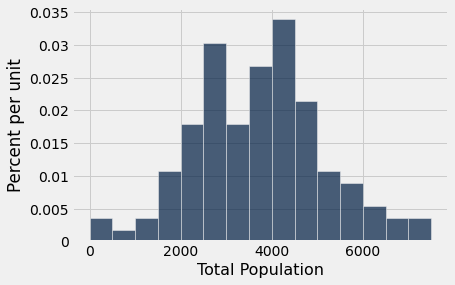

In [ ]:
oakland.hist("Total Population", bins=np.arange(0, 8000, 500))

Q: Looking back at the definition of census tracts, does the distribution of total population make sense? Why or why not?

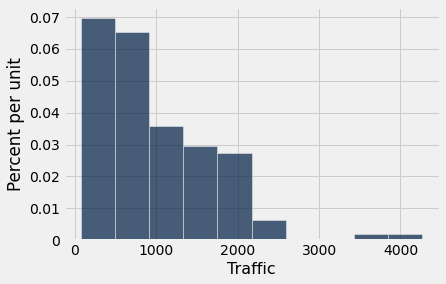

In [ ]:
oakland.hist("Traffic")

*Connect to definition of traffic, and why we may be seeing this distribution. Additionally, why might oakland see such a distribution?*

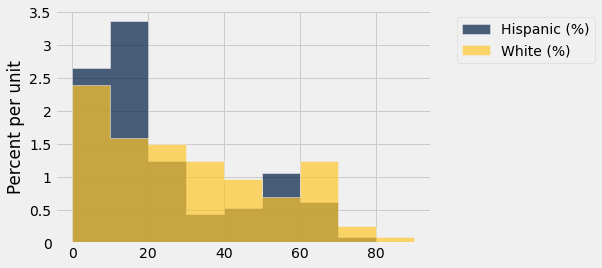

In [ ]:
oakland.hist("Hispanic (%)", "White (%)", bins=np.arange(0, 100, 10))

### Spatial Analysis

SOMETHING ABOUT SPATIAL DATA

In [ ]:
tracts = gpd.read_file("/content/drive/MyDrive/Colab Notebooks/ALPR/Alameda_CTracts.shp")

In [ ]:
add leading 0 to tabular data column to
oakland = oakland["Census Tract"].str.zfill(11)

In [ ]:
# Needs to get fixed... regardless, we don't expect students to understand this and we don't want them to. 
# The following are functions that add to the map functionality and expression.

def get_colors_from_column(tbl, col, include_outliers=False):
    """Assigns each row of the input table to a color based on the value of its percentage column."""
    vmin = min(tbl.column(col))
    vmax = max(tbl.column(col))

    if include_outliers:
        outlier_min_bound = vmin
        outlier_max_bound = vmax
    else:
        q1 = np.percentile(tbl.column(col), 25)
        q3 = np.percentile(tbl.column(col), 75)
        IQR = q3 - q1
        outlier_min_bound = max(vmin, q1 - 1.5 * IQR)
        outlier_max_bound = min(vmax, q3 + 1.5 * IQR)
        
    colorbar_scale = list(np.linspace(outlier_min_bound, outlier_max_bound, 10))
    scale_colors = ['#006100', '#3c8000', '#6ba100', '#a3c400', '#dfeb00', '#ffea00', '#ffbb00', '#ff9100', '#ff6200', '#ff2200']
    
    def assign_color(colors, cutoffs, datapoint):
        """Assigns a color to the input percent based on the data's distribution."""
        for i, cutoff in enumerate(cutoffs):
            if cutoff >= datapoint:
                return colors[i - 1] if i > 0 else colors[0]
        return colors[-1]
    
    colors = [""] * tbl.num_rows
    for i, datapoint in enumerate(tbl.column(col)): 
        colors[i] = assign_color(scale_colors, colorbar_scale, datapoint)
        
    return colors

In [ ]:
# Needs to be fixed... ideally clicking on a dot should present 'text' as shown in tbl line.
# The idea is that the other features and information are present (e.g., population demographics, pop size).

def map_feature(feature):
    
    colors = get_colors_from_column(oakland, feature, include_outliers=True) # Get colors based on percentiles
    
    # Note: normalize data then scale to increase
    factor = np.linalg.norm(oakland.column(feature))
    areas = (oakland.column(feature) / factor) * 10000
    
    tbl = oakland.select('Latitude', 'Longitude').with_columns('type', 'text', 'colors', colors, 'areas', areas)
    
    return tbl

In [ ]:
size_map(map_feature('Hispanic (%)'))

In [ ]:
size_map(map_feature('Traffic'))

## 5. Intersectional Analysis

An intersectional analysis between indicators, demographics, and space is important to...

*INCLDUE MAPS HERE*

**Q5a:** Which census tracts seem to be the most heavily surveilled? Which census tracts seem to be the least surveilled?

*Answer here*

**Q5b:** Take a look at the demographic data for the census tracts with high and low surveillance. Considering what you have learned about the history of surveillance on low-income, minority communities, do the patterns revealed by matching census tracts demographic data to the map surprise you? Why or why not?

*Answer here*

**Q5c:** How does the idea of ALPR data being used to help ‘fight crime’ connect with your findings from the map when race and class data are considered?

*Answer here*

## 6. Final Thoughts